In [70]:
# Import & Settings
import scipy.io
import json
import numpy as np
import pathlib
import os
import platform
import matplotlib.pyplot as plt
import cv2

DEVICE = 'cuda' if (platform.system() == "Windows") else 'cpu'

In [71]:
def load_matlab_data(mat_file):
    """Load data from a .mat file and store it in a dictionary."""
    file = pathlib.Path(mat_file)
    mat = scipy.io.loadmat(file)
    return mat
mat = load_matlab_data("10_60_min_comparison.mat")

<img src="./img/1.png" alt="1" width="300"/>

In [72]:
print(f".mat titles cnt: {len(mat.keys())}")
print(f"segmented frames cnt: {mat['Tracked_60min'].shape[1]}")
all_frames = mat["Tracked_60min"][0]

.mat titles cnt: 24
segmented frames cnt: 101


In [73]:
def convert(all_frames):
    converted: list[dict] = []
    for i in range(all_frames.shape[0]):
        cur = dict()
        # use try catch to avoid error on edge cases
        try:
            for j in range(100):
                cur[j] = all_frames[i][0,0][j][0]
        except IndexError:
            pass
        converted.append(cur)
    return converted

<img src="./img/2.png" alt="1" width="500"/>

In [74]:
def getCells(singleFrame, cellsLoc=2, cellsInfoIndex=12):
    ttlCellsInFrame = singleFrame[cellsLoc].shape[0]
    cells = []
    for i in range(ttlCellsInFrame):
        info = []
        cell = singleFrame[cellsLoc][i][0,0]
        for j in range(cellsInfoIndex):
            info.append(cell[j])
        cells.append(info)
    return cells

In [75]:
all_frames_converted = convert(all_frames)
frame_no_1 = all_frames_converted[0]

<img src="./img/3.png" alt="1" width="300"/>

In [76]:
all_cells_in_frame_no_1 = getCells(frame_no_1)

In [77]:
def imgDilation(cells):
    """Converts the cells into a binary matrix and then dilates it to get the edges of the cells."""
    dilated_matrix = scipy.ndimage.binary_dilation(cells)
    edge_matrix = dilated_matrix - cells
    return edge_matrix

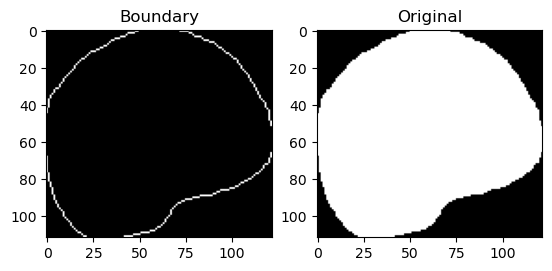

In [78]:
np.set_printoptions(threshold = np.inf)

boundary = plt.subplot(1, 2, 1)
boundary.set_title('Boundary')
boundary_matrix = imgDilation(all_cells_in_frame_no_1[0][0])
# print(f"bondary_matrix_first_col: \n{boundary_matrix[:, 0]}")
boundary.imshow(boundary_matrix, cmap='gray')
original = plt.subplot(1, 2, 2)
original.imshow(all_cells_in_frame_no_1[0][0], cmap='gray')
original.set_title('Original')
plt.show()

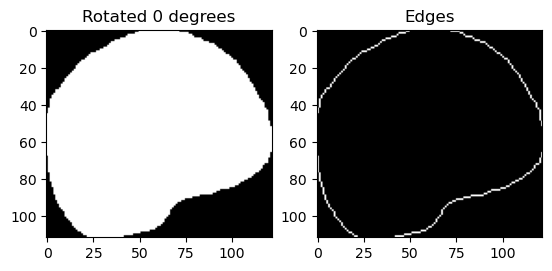

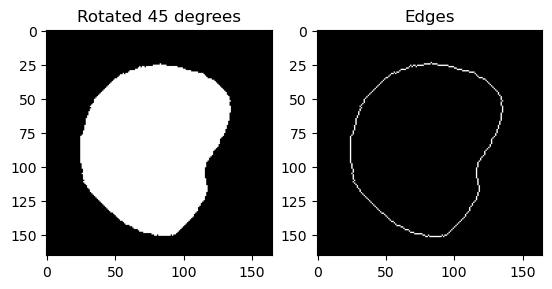

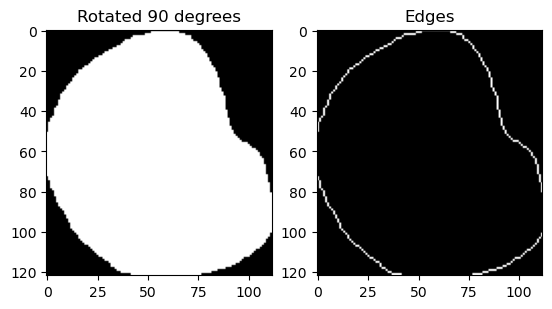

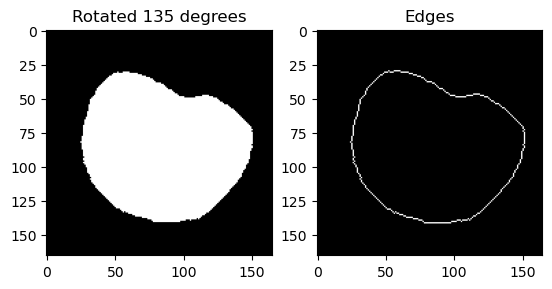

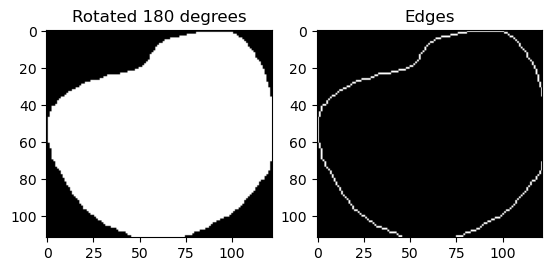

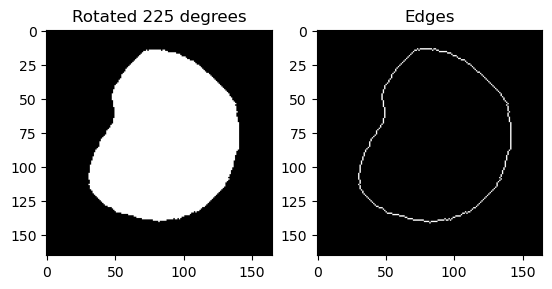

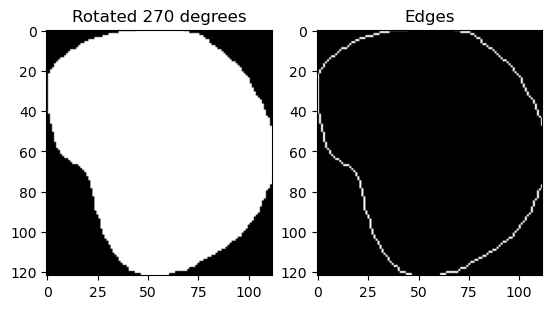

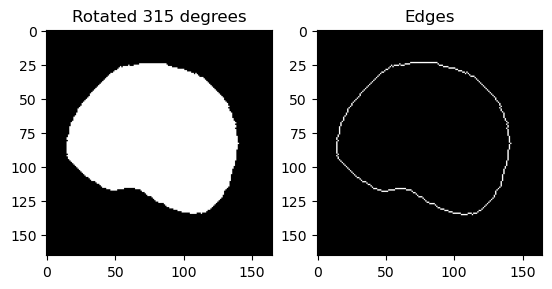

In [79]:
def imgRotation(cell, a):
    (h, w) = cell.shape[:2]
    angle = a
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # When rotating, the image corners might move outside of the frame
    # To fit the whole rotated image, calculate the new width and height
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # New width and height
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    rotated_image_matrix = cv2.warpAffine(cell, M, (new_w, new_h))
    return rotated_image_matrix

# Test and rotate the image by some degrees
for i in range(0, 360, 45):
    rotated = imgRotation(all_cells_in_frame_no_1[0][0], i)
    edged = imgDilation(rotated)
    rotated_plot = plt.subplot(1, 2, 1)
    rotated_plot.set_title(f'Rotated {i} degrees')
    rotated_plot.imshow(rotated, cmap='gray')
    edged_plot = plt.subplot(1, 2, 2)
    edged_plot.set_title('Edges')
    edged_plot.imshow(edged, cmap='gray')
    plt.show()